# MNIST分類

In [18]:
# 1. ライブラリインポートと学習データのダウンロード

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X, y = fetch_openml('mnist_784', data_home='./drive/My Drive/machine_learning/dataset', version=1, return_X_y=True)



In [2]:
# 学習データの前処理
X = X / 255
y = [float(s) for s in y]


X = np.reshape(X,(70000,28,28))
X = X[:,np.newaxis,:,:]
print('detaset shape',X.shape)

detaset shape (70000, 1, 28, 28)


6


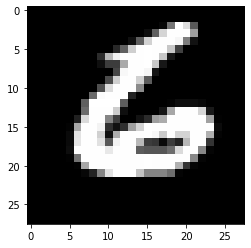

In [3]:
#学習データ表示

plt.imshow(X[-1,0,:,:], cmap=plt.cm.gray)
print("{:.0f}".format(y[-1]))

In [4]:
# 再現性担保のための乱数固定
torch.manual_seed(0)

In [5]:
# データセット作成
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=0)

print(type(y_train[0]))
print(X_train[0].shape)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)

<class 'float'>
(1, 28, 28)


In [6]:
# モデル設計

from torch import nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3) # 28x28x32 -> 26x26x32
        self.conv2 = nn.Conv2d(32, 64, 3) # 26x26x64 -> 24x24x64 
        self.pool = nn.MaxPool2d(2, 2) # 24x24x64 -> 12x12x64

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))

        return x


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.encoder = Encoder()
        self.dropout1 = nn.Dropout2d()
        self.fc1 = nn.Linear(12 * 12 * 64, 128)
        self.dropout2 = nn.Dropout2d()
        self.fc2 = nn.Linear(128, 10)
      
    def forward(self, x):
        x = self.encoder(x)
        x = self.dropout1(x)
        x = x.contiguous().view(-1, 12 * 12 * 64)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x



model = CNN()

model.to(device)
print(model)

CNN(
  (encoder): Encoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [7]:
# 誤差関数と最適化手法の設定

from torch import optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 学習の設定

def train(epoch):
  model.train()

  for data, targets in loader_train:
    data, targets = data.cuda(), targets.cuda()

    optimizer.zero_grad()
    outputs = model(data)
    loss = loss_fn(outputs, targets)

    loss.backward()
    optimizer.step()

  print("epoch{}:終了\n".format(epoch))



# 推論の設定

def test():
  model.eval()
  correct = 0
  predicted_score = torch.zeros(y_test.size()[0])

  with torch.no_grad():
    for idx,(data, targets) in enumerate(loader_test):
      data, targets = data.cuda(), targets.cuda()

      outputs = model(data)

      _, predicted = torch.max(outputs.data, 1)
      predicted_score[idx*64:(idx+1)*64] = predicted
      correct += predicted.eq(targets.data.view_as(predicted)).sum()

  data_num = len(loader_test.dataset)
  print('\nテストデータの正解率：{}/{}({:.0f}%)\n'.format(correct, data_num, 100. * correct /data_num))

  return predicted_score

In [8]:
# 学習前のテストデータ正解率

_ =  test()


テストデータの正解率：695/10000(7%)



In [9]:
# 7. 学習後のテストデータ正解率

for epoch in range(3):
  train(epoch)

y_pred = test()

epoch0:終了

epoch1:終了

epoch2:終了


テストデータの正解率：9866/10000(99%)



In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       996
           1       0.99      0.99      0.99      1141
           2       0.99      0.98      0.99      1040
           3       0.99      0.99      0.99      1013
           4       0.98      0.99      0.99       962
           5       0.98      0.99      0.98       863
           6       0.98      0.99      0.99       989
           7       0.98      0.99      0.98      1064
           8       0.99      0.98      0.98       963
           9       0.99      0.97      0.98       969

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



# 以下、考察用データ

In [11]:
# 混同行列の作成

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 990    0    0    0    1    0    4    0    1    0]
 [   0 1134    2    1    1    0    1    2    0    0]
 [   1    0 1024    3    1    0    1    6    3    1]
 [   1    0    3 1001    0    4    0    1    2    1]
 [   1    1    0    0  955    0    2    1    0    2]
 [   0    0    1    3    0  853    5    0    0    1]
 [   2    0    0    0    1    7  979    0    0    0]
 [   0    3    7    0    2    0    0 1051    1    0]
 [   1    4    1    1    1    1    4    1  942    7]
 [   3    0    1    3    8    4    0    9    4  937]]


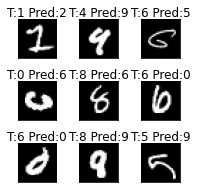

In [12]:
# 間違えたサンプルの抽出と一部図示

model.eval()
mis_recog = set() 

for idx in range(X_test.shape[0]):
  data = X_test[idx]
  data = data[np.newaxis,:,:]
  data = data.cuda()
  output = model(data)
  _, predicted = torch.max(output.data[0], 0)

  if int(predicted) is not int(y_test[idx]):
    mis_recog.add((idx,int(predicted)))

mis = list(mis_recog)


fig = plt.figure(figsize=(3, 3))

from pylab import rcParams

rcParams['figure.figsize'] = 20,20

# 余白を設定
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i,idx in enumerate(mis[:9]):
    x = X_test[idx[0]]
    im = x.view(-1, 28, 28).permute(1, 2, 0).squeeze().numpy()
    ax = fig.add_subplot(3, 3, i+1, xticks=[], yticks=[])
    ax.set_title('T:'+str(int(y_test[idx[0]]))+' Pred:'+str(idx[1]),pad=0)
    ax.imshow(im, 'gray')


In [13]:
# 画像データから特徴量抽出

features_test = []

for idx in range(X_test.shape[0]):
    tmp = X_test[np.newaxis,idx,:,:]
    tmp = tmp.cuda()
    tmp = model.encoder(tmp)
    tmp = tmp.reshape(-1)
    tmp = tmp.cpu().detach().numpy()
    features_test.append(tmp)

features_train = []

for idx in range(X_train.shape[0]):
    tmp = X_train[np.newaxis,idx,:,:]
    tmp = tmp.cuda()
    tmp = model.encoder(tmp)
    tmp = tmp.reshape(-1)
    tmp = tmp.cpu().detach().numpy()
    features_train.append(tmp)

features_train = np.array(features_train)
features_test = np.array(features_test)

features = np.vstack((features_train,features_test))

In [14]:
#メモリ確保のための変数除去

del features_test
del features_train

In [15]:
# 主成分分析を用いて特徴量の次元削減

from sklearn.decomposition import PCA
pca = PCA(n_components=30)
pca.fit(features)
reduced_feature = pca.transform(features)

In [16]:
#メモリ確保のための変数除去

del features

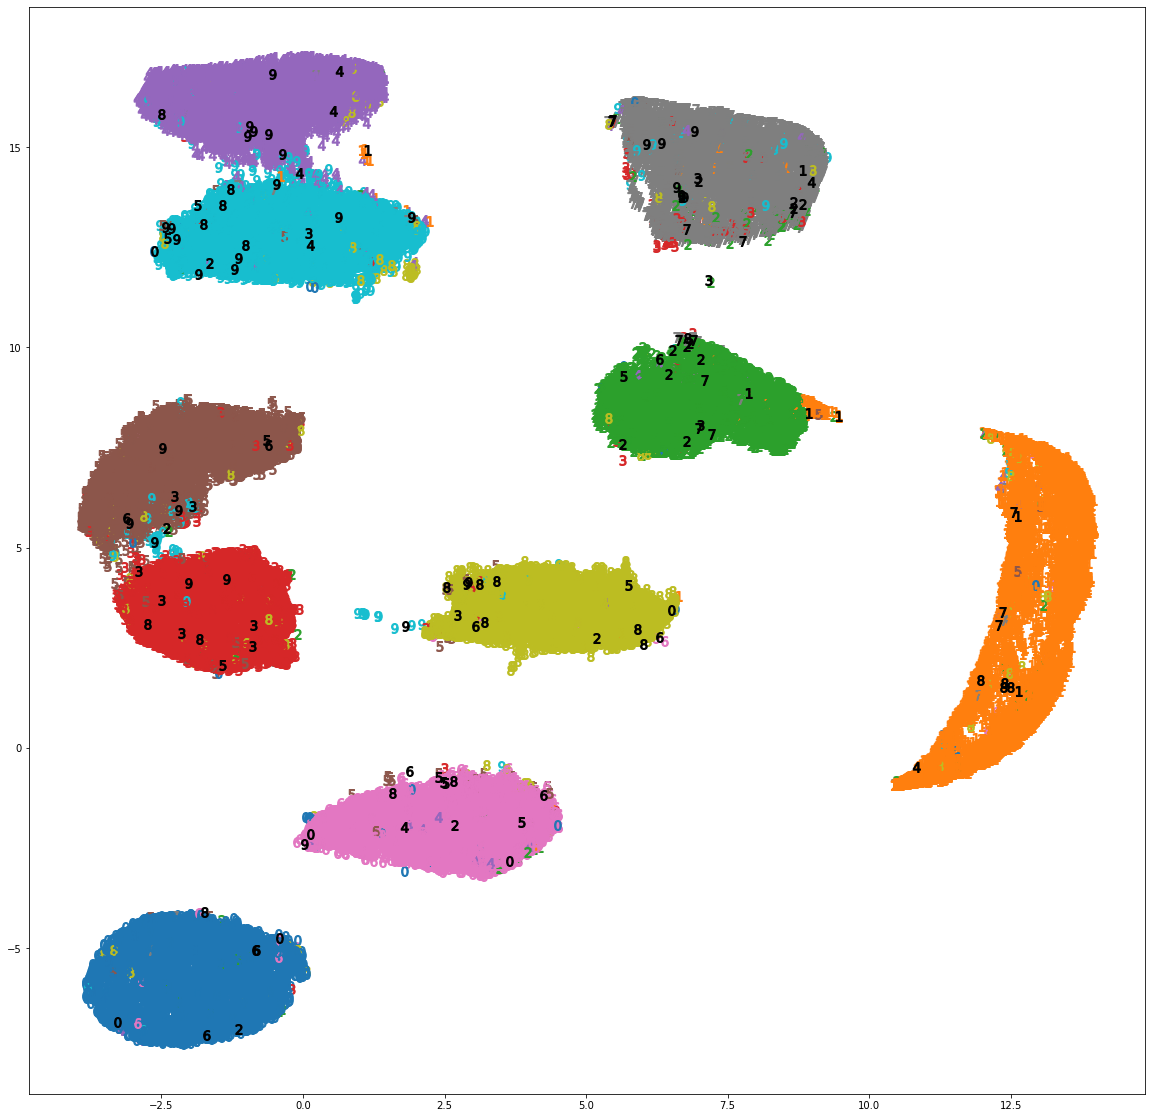

In [17]:
# umapによる特徴量空間の可視化
import umap

mapper = umap.UMAP()
umap_embedding = mapper.fit_transform(reduced_feature)

cmap = plt.get_cmap("tab10") 

for idx in range(y_train.shape[0]):
    plt.plot(umap_embedding[idx,0],umap_embedding[idx,1],marker='$'+str(int(y_train[idx]))+'$',markersize=10,color=cmap(int(y_train[idx])))

for idx in mis:
    plt.plot(umap_embedding[idx[0]+60000,0],umap_embedding[idx[0]+60000,1],marker='$'+str(int(y_test[idx[0]]))+'$',markersize=10,color='k')

print('形:true class')
print('色:黒→test dataで誤分類したサンプル　その他→train dataで、同色は同じクラス')